# Hands On Session: Uncovering brain-behavior relationships and overcoming overfitting with regularization

In this section, we're going to use tools learnt in Section 1 and learn about methods to uncover relationships between hypothalamic neural activity and social behavior using a dataset from [Remedios et ., 2017, Nature](https://https://www.nature.com/articles/nature23885)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SaberaTalukder/Chen_Institute_DataSAI_for_Neuroscience/blob/main/07_05_22_day1_overview/code/diy_notebooks/overfitting_regularization.ipynb)

In [1]:
# Import neccessary modules and helper functions
# Sort imports alphabetically

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def forceAspect(ax,aspect):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)
    

### But first!
A bit more about our dataset: the data you examined in part 1 comes from a head-mounting microendoscope which collected calcium imaging (GCaMP6s) data from a male mouse enaging in either mating behavior towards a female or aggressive behavior towards a male. After collection of the imaging data, a data extraction pipeline is used to identify cells and extract time evolving traces from the imaging video. Finally, experimenters perform computer-vision assisted annotation of behaviors to give you the behavior label binary vectors you are using today

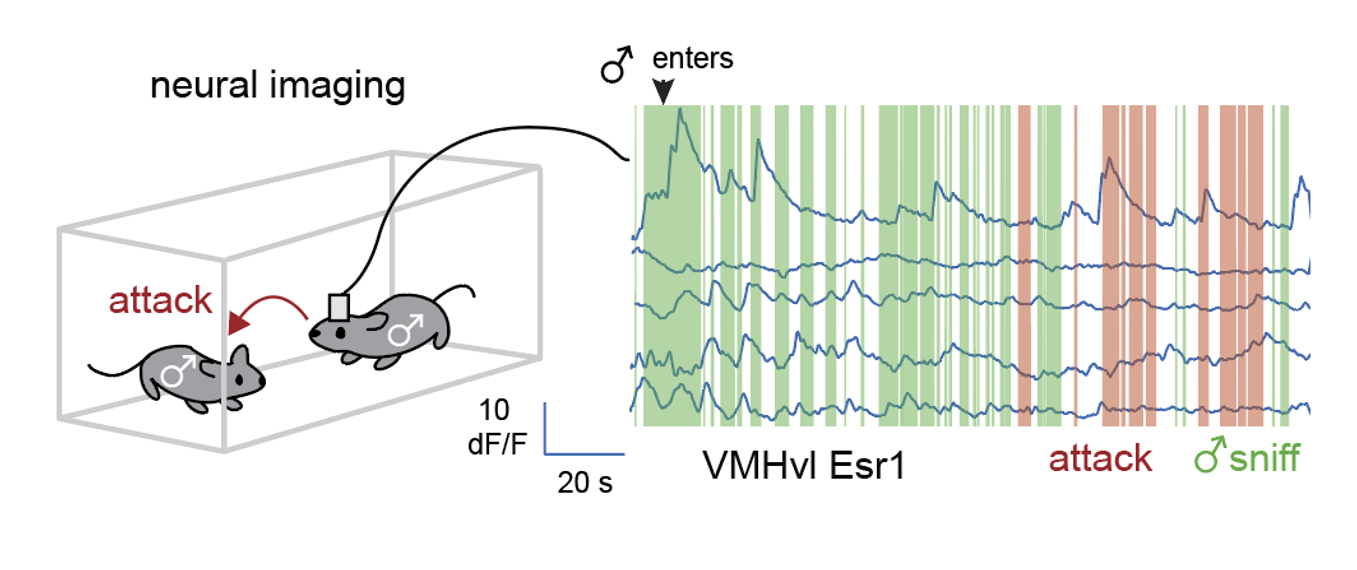

### Load data

In [2]:

remedios_data = loadmat("vmhvl_remedios.mat");
neural_data = remedios_data['neural_data']
attack_vector = remedios_data['attack_vector']
sex_vector = remedios_data['sex_vector']


### 1 a) Visualize neural and behavior data 
Now that we've examined neural activity of VMHvl in session 1, let's plot both a behavior raster showing attack behavior (present in attack_vector) and neural activity together. 

Attack is a behavior causally linked to VMHvl activity: activation this hypothalamus brain region using optogenetic can produce aggression (see: [Lin et ., 2011, Nature](https://www.nature.com/articles/nature09736) for some cool videos)

<br>

#### Generate a plot showing the behavior annotation array attack_vector along with neural activity below:

In [3]:
# Enter code here:

Text(0, 0.5, 'neurons')

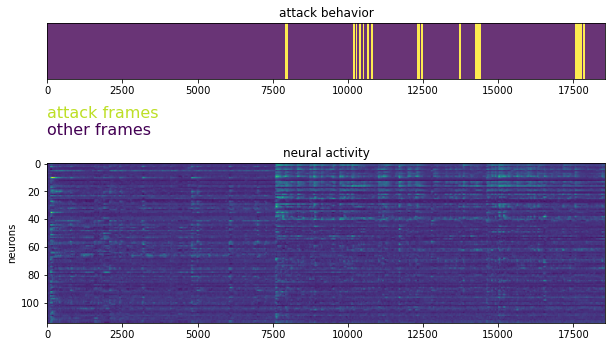

In [4]:
# Solution

# Plot behavior raster
plt.figure(figsize=[10,10])
ax1 = plt.subplot(311)
cmap = matplotlib.cm.get_cmap('viridis')

ax1.imshow(attack_vector, aspect='auto', alpha = 0.8, interpolation = 'nearest')
forceAspect(ax1,aspect=10)
ax1.set_yticks([])
ax1.set_title('attack behavior')
ax1.text(0,1.2,'attack frames',color = cmap(0.9),fontsize=16)
ax1.text(0,1.5,'other frames',color = cmap(0.0),fontsize=16)

ax2 = plt.subplot(312)
ax2.imshow(neural_data, aspect='auto')
ax2.set_title('neural activity')
ax2.set_ylabel('neurons')

### 1 b) Redo PCA!
As you can see, attack is a rare behavior. You have also quantified this in section 1 using histograms. Let's now use what we learnt in Section 1 to perform PCA on this data and examine the top 2 principal components. This time, let's color each data point by the behavior associated with it in the attack_vector annotation array

<br>

#### Generate a PCA plot colored by the behavior annotation array attack_vector below:

In [5]:
# Enter code here:

Text(0.02, 0.017, 'attack')

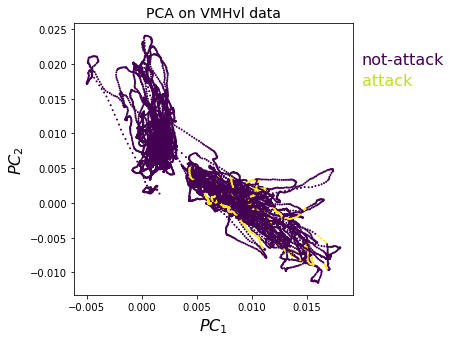

In [6]:
# Solution

# perform PCA
pca_neural = PCA(n_components=2)
pca_neural.fit_transform (neural_data)
neural_pcs = pca_neural.components_

# plot PCA, colored by intruder sex
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111)
cmap = matplotlib.cm.get_cmap('viridis')

# neural_pcs.shape
ax.scatter(neural_pcs[0,],neural_pcs[1,], c = attack_vector, s = 1)
ax.set_title('PCA on VMHvl data',fontsize = 14)
ax.set_xlabel('$PC_1$',fontsize=16)
ax.set_ylabel('$PC_2$',fontsize=16)
ax.text(0.02,0.02,'not-attack',color = cmap(0.0),fontsize=16)
ax.text(0.02,0.017,'attack',color = cmap(0.9),fontsize=16)


### 2) Correlating behavior and neural activity using linear regression
### a) Train Test Split 
Attack behavior is fairly rare in our dataset, let's train a simple linear regression model to estimate if attack can be decoded from this population.

In regression, we predict the behavior as a linear combination of the activity of neurons, as follows: $y = \alpha + \beta_1 x_1 + \beta_2 x_2 ... + \beta_n x_n$.

where $y$ is the behavior we predict and $x_1, x_2, ... , x_n$ are the activities of individual neurons at a given time point.

The first step involves splitting data into train & test splits. As a first pass, let's split the last third of the data into the test set

<br>

#### Generate a train-test split in your dataset below (hint: use the function [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) from sklearn)

In [7]:
# Enter code here:

In [8]:
# Solution

# generate test split as last 1/3rd of data
X_train, X_test, y_train, y_test = train_test_split(neural_data.T, 
                                                    attack_vector[0,].T,
                                                    test_size=0.33, 
                                                    shuffle = False,
                                                    random_state=42)

### 2 b) Performing regression

We will use sklearn's [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) module to perform the actual regression. 

This can be implemented in just a single line of code thanks to sklearn! 

#### Generate a regression model using sklearn's [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) function

In [9]:
# Enter code here:

In [10]:
# Solution

# perform linear regression
reg = LinearRegression().fit(X_train, y_train)

### 2 c) Prediction and quatifying performance

To quantify performance, we show a confusion matrix with quantifies the degree of false positives and false negative for each class (attack and not-attack). These metrics can then be used to calculate an accuracy and precision value for each class. We use sklearn's [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) module to perform this. 
<br>
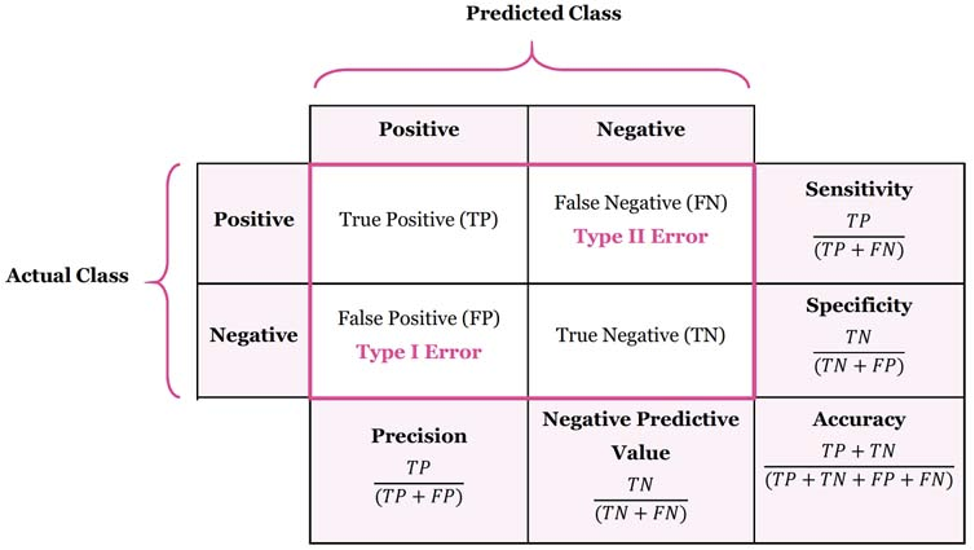

Keep in mind, the output of regression will be a number, not a class label. This output represents a probability (but can be negative since linear regression does not impose non-negativity). We need to threshold the output by a value (say 0.4 as an example) to generate a binary signal that be compared with attack_vector.
<br>
#### Use sklearn's [predict](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.predict) and [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) to quantify performance of your linear model

In [11]:
# Enter code here

Text(0.5, 1.0, 'regression test performance for attack')

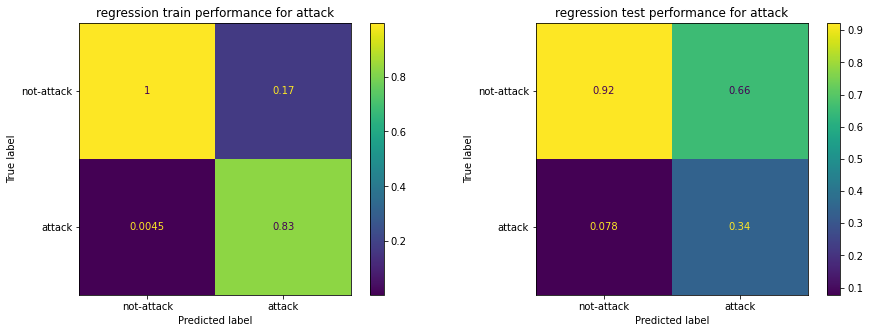

In [12]:
# Solution

# Training performance:
train_y_pred = reg.predict(X_train)
train_y_pred_bin = np.zeros((1,np.size(X_train[:,0])))
train_y_pred_bin[0,np.where(train_y_pred>0.4)] = 1

cm_train = confusion_matrix(y_train, train_y_pred_bin[0,], normalize = "pred")
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, 
                                    display_labels=["not-attack", "attack"])

# Testing performance:
test_y_pred = reg.predict(X_test)
test_y_pred_bin = np.zeros((1,np.size(X_test[:,0])))
test_y_pred_bin[0,np.where(test_y_pred>0.4)] = 1

cm_test = confusion_matrix(y_test, test_y_pred_bin[0,], normalize = "pred")
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, 
                                   display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(122)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')


This approach reveals perhaps the most common problem faced in ML, namely overfitting. Here, the train performance of the linear model suggests that model has learnt to distinguish attack frames, however when applied on a held out test dataset, the model performance collapses.

Let's also observe this as a behavior raster:

<br>

#### Create a plot showing both the predicted behavior raster and actual behavior raster for attack

In [13]:
# Enter code here:

Text(0, 1.5, 'other frames')

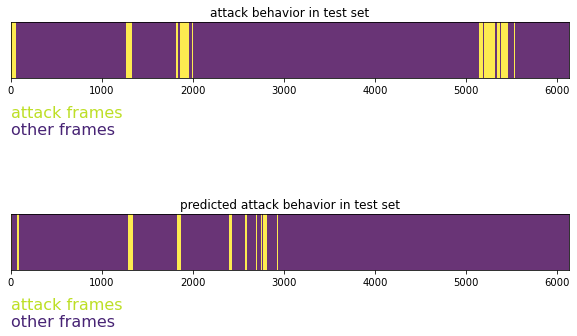

In [16]:
# Solution

# plot neural activity, showing frames of attack
plt.figure(figsize=[10,10])
ax1 = plt.subplot(311)
y_test_plot = np.expand_dims(y_test, axis=0)
ax1.imshow(y_test_plot, aspect='auto', alpha = 0.8, interpolation = 'nearest')
forceAspect(ax1,aspect=10)
ax1.set_yticks([])
ax1.set_title('attack behavior in test set')
ax1.text(0,1.2,'attack frames',color = cmap(0.9),fontsize=16)
ax1.text(0,1.5,'other frames',color = cmap(0.1),fontsize=16)

ax2 = plt.subplot(312)
ax2.imshow(test_y_pred_bin, aspect='auto', alpha = 0.8, interpolation = 'nearest')
forceAspect(ax2,aspect=10)
ax2.set_yticks([])
ax2.set_title('predicted attack behavior in test set')
ax2.text(0,1.2,'attack frames',color = cmap(0.9),fontsize=16)
ax2.text(0,1.5,'other frames',color = cmap(0.1),fontsize=16)

### 3 a) Overcoming Overfitting: Model selection

To overcome overfitting, we apply regularization, a method where a penalty is introduced to curb overfitting. Different types of regularization exist, here we will apply LASSO (least absolute shrinkage and selection operator), a method that allows us to enforce sparsity in predicted weighted from linear regression:

Most methods in machine learning always involving comparing a data point with it's predicted value. This can be written as: $y - \beta x $ in the case of linear regression. The goal of machine learning is to estimate a value of $\beta$ that minimizes this error that we also call a loss function. In regularization, we apply a penalty to this error, which for LASSO is as follows:

$(y - \beta x) + \lambda \sum_{i = 1}^{p} |\beta_i|$

The value of lamba specifies the amount of regularization and is selected by cross-validation, a process where the training data is split into several 'folds' or portions and the model is trained on some folds and tested on the held-out fold. This is a process called model selection and is vital to most ML methods.

Lasso can be implemented using sklearn's [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html). 

#### Read the help sklearn [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) help page and generate a lasso model with cross validation below

In [17]:
# Enter code here

Text(0.5, 1.0, 'model selection for lasso')

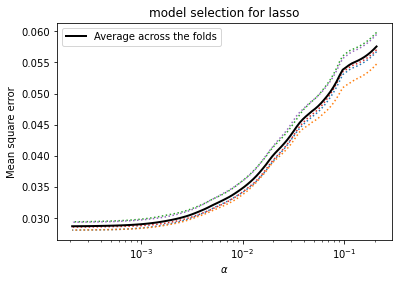

In [18]:
# Solution

from sklearn.linear_model import LassoCV
# from sklearn.linear_model import RidgeCV

# generate test split as last 1/3rd of data
X_train, X_test, y_train, y_test = train_test_split(neural_data.T, 
                                                    attack_vector[0,].T,
                                                    test_size=0.3, 
                                                    shuffle = True,
                                                    random_state=42)

# lasso = LassoCV(cv=5, random_state=0).fit(X_train, y_train)
lasso = LassoCV(cv=5, random_state=0).fit(X_train, y_train)

plt.semilogx(lasso.alphas_, lasso.mse_path_, linestyle=":")
plt.plot(
    lasso.alphas_,
    lasso.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)

# plt.axvline(lasso.alpha_, linestyle="--", color="black", label="alpha: CV estimate")

plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
plt.title("model selection for lasso")

### 3 b) Lasso model performance

#### Use the code you wrote earlier to create predict data on the held out test set and create confusion matrices below

In [19]:
# Enter code here:

Text(0.5, 1.0, 'regression test performance for attack')

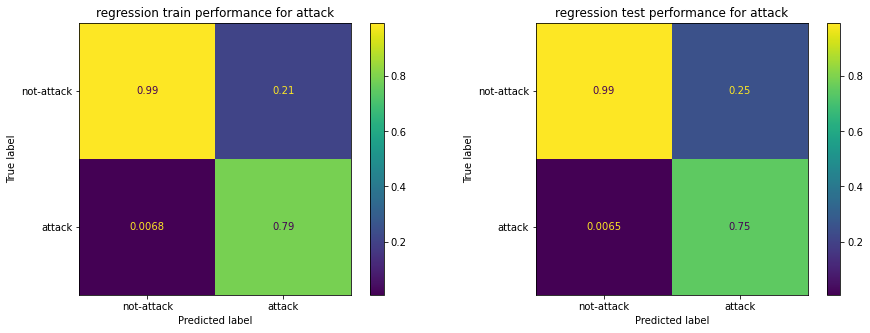

In [20]:
# Solution

# Training performance:
train_y_pred = lasso.predict(X_train)
train_y_pred_bin = np.zeros((1,np.size(X_train[:,0])))
train_y_pred_bin[0,np.where(train_y_pred>0.4)] = 1

cm_train = confusion_matrix(y_train, train_y_pred_bin[0,], normalize = "pred")
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, 
                                    display_labels=["not-attack", "attack"])

# Testing performance:
test_y_pred = lasso.predict(X_test)
test_y_pred_bin = np.zeros((1,np.size(X_test[:,0])))
test_y_pred_bin[0,np.where(test_y_pred>0.4)] = 1

cm_test = confusion_matrix(y_test, test_y_pred_bin[0,], normalize = "pred")
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, 
                                   display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(122)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')


#### Our LASSO model works!!


Thus, we can now plot what the predicted attack in VMHvl using our regression model looks like in out entire dataset. 

#### Create a plot showing the actual attack behavior raster, predicted behavior raster and neural activity together

In [21]:
# Enter code here:

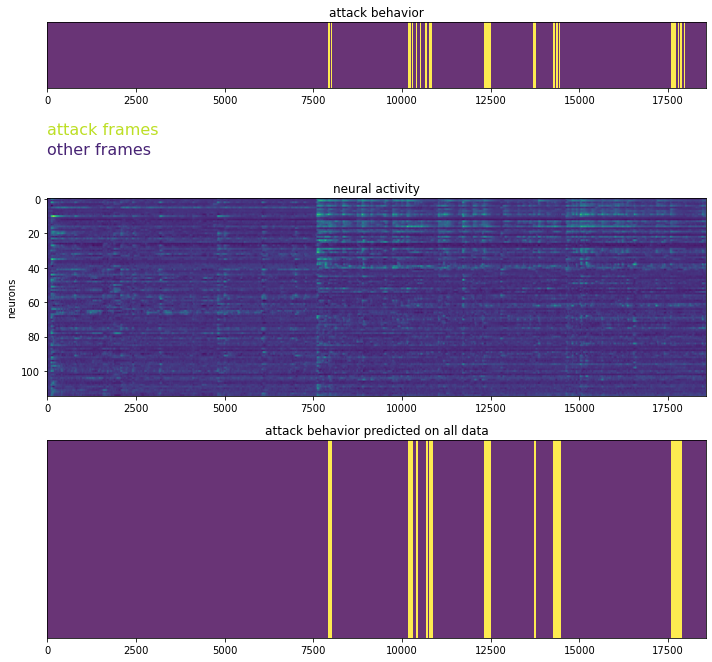

In [22]:
# Solution: 

# plot neural activity, showing frames of attack
all_y_pred = lasso.predict(neural_data.T)
all_y_pred_bin = np.zeros((1,np.size(neural_data[0,:])))
all_y_pred_bin[0,np.where(all_y_pred>0.4)] = 1

plt.figure(figsize=[10,10])
ax1 = plt.subplot(311)
cmap = matplotlib.cm.get_cmap('viridis')

ax1.imshow(attack_vector, aspect='auto', alpha = 0.8, interpolation = 'nearest')
forceAspect(ax1,aspect=10)
ax1.set_yticks([])
ax1.set_title('attack behavior')
ax1.text(0,1.2,'attack frames',color = cmap(0.9),fontsize=16)
ax1.text(0,1.5,'other frames',color = cmap(0.1),fontsize=16)

ax2 = plt.subplot(312)
ax2.imshow(neural_data, aspect='auto')
ax2.set_title('neural activity')
ax2.set_ylabel('neurons')

ax3 = plt.subplot(313)
ax3.imshow(all_y_pred_bin, aspect='auto', alpha = 0.8, interpolation = 'nearest')
forceAspect(ax1,aspect=10)
ax3.set_yticks([])
ax3.set_title('attack behavior predicted on all data')

plt.tight_layout() 